## Setting Up

### Import packages here

In [1]:
import pickle
import glob as gl
from numpy import isnan, append

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors
import cmocean
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from preprocessing.timeseries import extract_timeseries_at_locations, align_model_with_observations

In [2]:
# some parameters
plt.rcParams.update({'font.size': 14})
dpi = 200

In [3]:
def get_full_name(run_numbers,prefix):
    runs_full_name = []
    for run in run_numbers:
        runs_full_name.append(prefix + str(run))
    return runs_full_name

In [4]:
def get_wrf_lists(run_numbers,prefix):
    wrf_lists = []
    for rdx,run in enumerate(run_numbers):
        wfv_dir = proj_dir + prefix + str(run) + '/'
        wrf_list = gl.glob(wfv_dir + 'output_wrf/cstm_d01*')
        if not wrf_list:
            wfv_dir = proj_dir + prefix + str(run).rjust(2,'0') + '/'
            wrf_list = gl.glob(wfv_dir + 'output_wrf/cstm_d01*')  
        wrf_list.sort()
        wrf_lists.append(wrf_list)
        if rdx == 0:
            print(wrf_list[0:2])
            
    return wrf_lists

In [5]:
def get_fvcom_lists(run_numbers,prefix):
    fv_lists = []
    for rdx,run in enumerate(run_numbers):
        wfv_dir = proj_dir + prefix + str(run) + '/'
        fv_list = gl.glob(wfv_dir + 'output_fvcom*/gl_0*.nc')
        if not fv_list:
            wfv_dir = proj_dir + prefix + str(run).rjust(2,'0') + '/'
            fv_list = gl.glob(wfv_dir + 'output_fvcom*/gl_0*.nc')
        fv_list.sort()
        fv_lists.append(fv_list)
        if rdx == 0:
            print(fv_list[0:2])
        
    return fv_lists

### Set the directories and get list of filenames

In [6]:
# year and month of anaylsis
year = 2018
months = [6,7,8]

# directories
proj_dir = '/lus/grand/projects/COMPASS-GLM/'
home_dir = proj_dir + 'GLM_Evaluation/'
buoy_dir = home_dir + 'NDBC/'
wrf_meta_dir = home_dir + 'WRF_metadata/'

# filenames
buoy_file = '../output/buoy_2018_JJA_processed.pkl' # buoy data
proj_dir = '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/' # wrf + fvcom coupled

# information of the different sets (training, test, and bayesian optimized)
train_dict = {'run_numbers': range(1,19),
              'run_names': get_full_name(run_numbers=range(1,19),prefix='9_variable_korobov_'),
              'wrf_lists': get_wrf_lists(run_numbers=range(1,19),prefix='run'),
              'fvcom_lists': get_fvcom_lists(run_numbers=range(1,19),prefix='run'),
              'output_filename': '../output/wfv_buoy_temperature_training_set.pkl'}
test_dict = {'run_numbers': [1,3,5,6,9],
             'run_names': get_full_name(run_numbers=[1,3,5,6,9],prefix='8_variable_korobov_'),
             'wrf_lists': get_wrf_lists(run_numbers=[1,3,5,6,9],prefix='korobov_run'),
             'fvcom_lists': get_fvcom_lists(run_numbers=[1,3,5,6,9],prefix='korobov_run'),
             'output_filename': '../output/wfv_buoy_temperature_test_set.pkl'}

bo_dict = {'run_numbers': ['run_BO1'],
           'run_names': get_full_name(run_numbers=['run_BO1'],prefix='9_variable_'),
           'wrf_lists': get_wrf_lists(run_numbers=['run_BO1'],prefix=''),
           'fvcom_lists': get_fvcom_lists(run_numbers=['run_BO1'],prefix=''),
           'output_filename': '../output/wfv_buoy_temperature_BO1.pkl'}

set_dict = {'training_set': train_dict,
            'test_set': test_dict,
            'bo_set': bo_dict}

all_output_filename = '../output/wfv_buoy_temperatures_all_processed.pkl'

['/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run01/output_wrf/cstm_d01_2018-05-12_00:00:00', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run01/output_wrf/cstm_d01_2018-05-12_01:00:00']
['/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run01/output_fvcom0/gl_0001.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/run01/output_fvcom0/gl_0002.nc']
['/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/korobov_run1/output_wrf/cstm_d01_2018-05-12_00:00:00', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/korobov_run1/output_wrf/cstm_d01_2018-05-12_01:00:00']
['/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/korobov_run1/output_fvcom0/gl_0001.nc', '/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ensemble/korobov_run1/output_fvcom0/gl_0002.nc']
['/lus/theta-fs0/projects/RCM_4km/GL_CoupledModelUQ/Summer_2018_Ense

### Read NBDC buoy data

In [7]:
with open(buoy_file, 'rb') as fp:
    buoy_data = pickle.load(fp)
    print('Done read bouy_data')

Done read bouy_data


In [8]:
# make buoy lon and lat vectors
buoy_names = [bd['name'] for bd in buoy_data]
buoy_lon = [bd['lon'] for bd in buoy_data]
buoy_lon2 = [bd['lon']+360 for bd in buoy_data]
buoy_lat = [bd['lat'] for bd in buoy_data]

## Processing

In [9]:
# choose which set to do..
this_list = set_dict['test_set']

### Get time series of WRF+FVCOM temperatures at the buoy_locations

In [10]:
# open the existing file
with open(this_list['output_filename'], 'rb') as fp:
    wfv_runs = pickle.load(fp)

## Plotting for checking

In [11]:
buoy_av_LST = [bd['data']['LST'].mean() for bd in buoy_data]
buoy_av_T2 = [bd['data']['T2'].mean() for bd in buoy_data]

### Plot buoy locations and mean temps

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


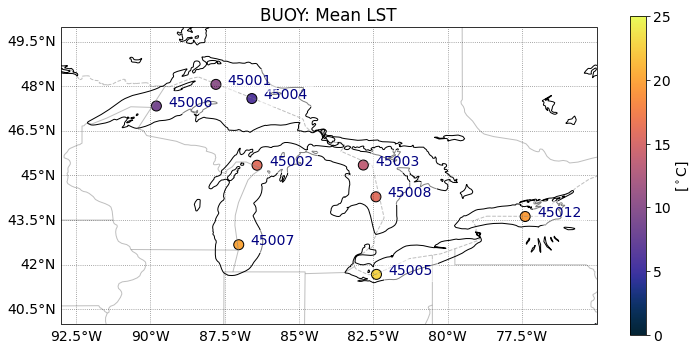

In [12]:
# Create a figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent([-93, -75, 40,50])

# Download and add the states and coastlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(cfeature.BORDERS, edgecolor='gray',linestyle="dashed", alpha=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        facecolor='none',        
        scale='50m')
ax.add_feature(lakes)

vmin = 0
vmax = 25

plt.scatter(buoy_lon,buoy_lat,s=100,
            c=buoy_av_LST,cmap=cmocean.cm.thermal,vmin=vmin,vmax=vmax,edgecolor='black') 
for idx,buoy_name in enumerate(buoy_names):
    if isnan(buoy_av_LST[idx]):
        plt.plot(buoy_lon[idx],buoy_lat[idx],'rx')
    plt.annotate(buoy_name,(buoy_lon[idx]+0.4,buoy_lat[idx]),
                 color='navy',backgroundcolor=(1,1,1,0.5))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98, label='[$^\circ$C]')

# Add the gridlines
gll = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
gll.xlabels_top = None
gll.ylabels_right = None
gll.xformatter = LONGITUDE_FORMATTER
gll.yformatter = LATITUDE_FORMATTER

plt.title("BUOY: Mean LST")

plt.show()
#fig.savefig('buoy_mean_LST.png',format='png',dpi=dpi,bbox_inches='tight')

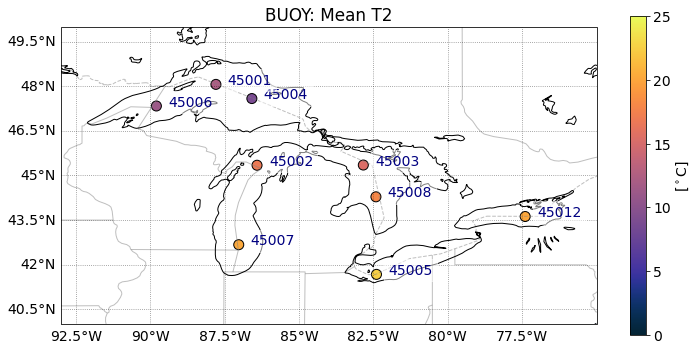

In [13]:
# Create a figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent([-93, -75, 40,50])

# Download and add the states and coastlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(cfeature.BORDERS, edgecolor='gray',linestyle="dashed", alpha=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(states_provinces, edgecolor='gray', alpha=0.5)
lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        facecolor='none',        
        scale='50m')
ax.add_feature(lakes)

vmin = 0
vmax = 25

plt.scatter(buoy_lon,buoy_lat,s=100,
            c=buoy_av_T2,cmap=cmocean.cm.thermal,vmin=vmin,vmax=vmax,edgecolor='black') 
for idx,buoy_name in enumerate(buoy_names):
    if isnan(buoy_av_LST[idx]):
        plt.plot(buoy_lon[idx],buoy_lat[idx],'rx')
    plt.annotate(buoy_name,(buoy_lon[idx]+0.4,buoy_lat[idx]),
                 color='navy',backgroundcolor=(1,1,1,0.5))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98, label='[$^\circ$C]')

# Add the gridlines
gll = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
gll.xlabels_top = None
gll.ylabels_right = None
gll.xformatter = LONGITUDE_FORMATTER
gll.yformatter = LATITUDE_FORMATTER

plt.title("BUOY: Mean T2")

plt.show()

### Plot buoy timeseries

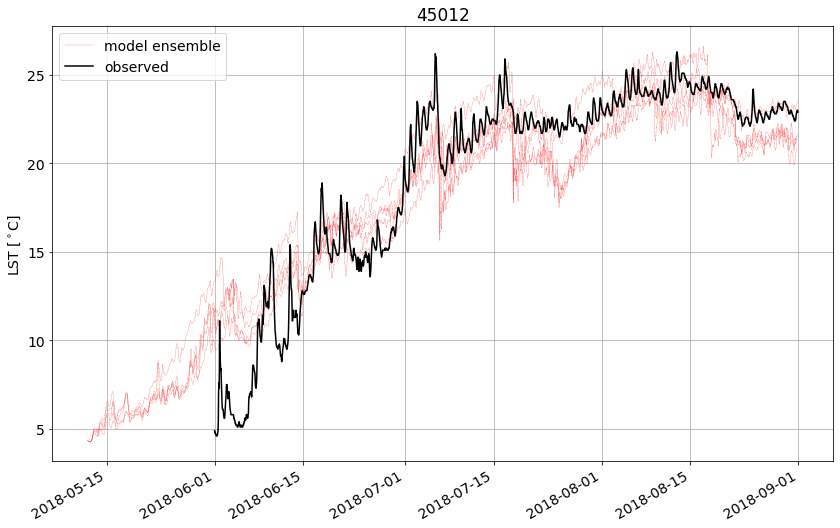

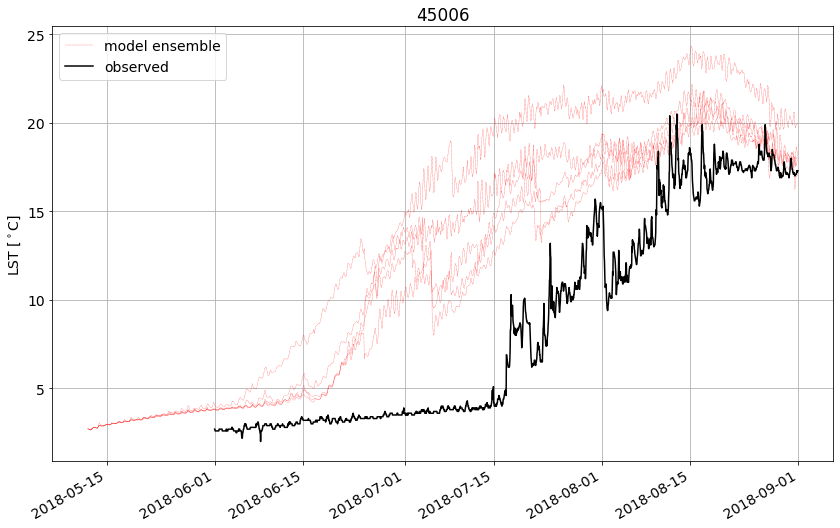

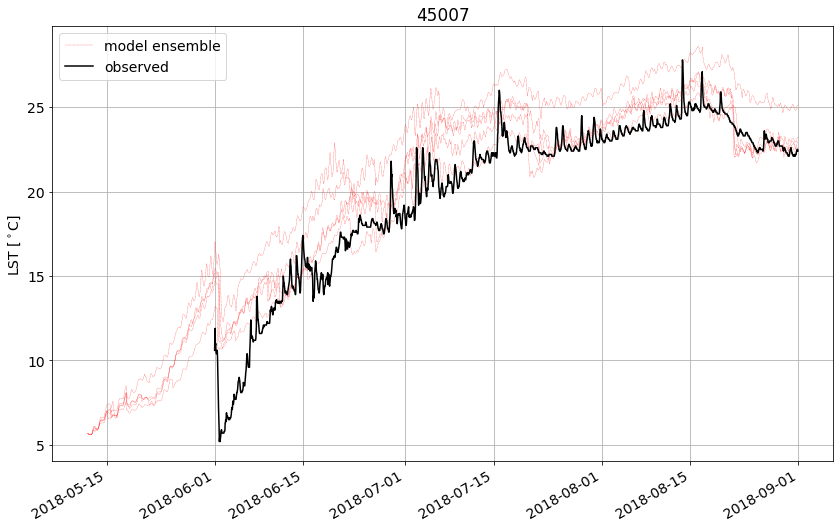

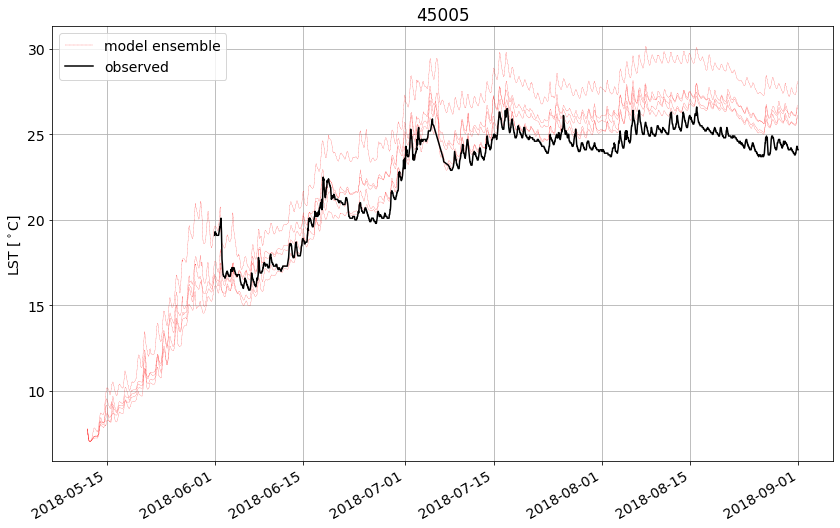

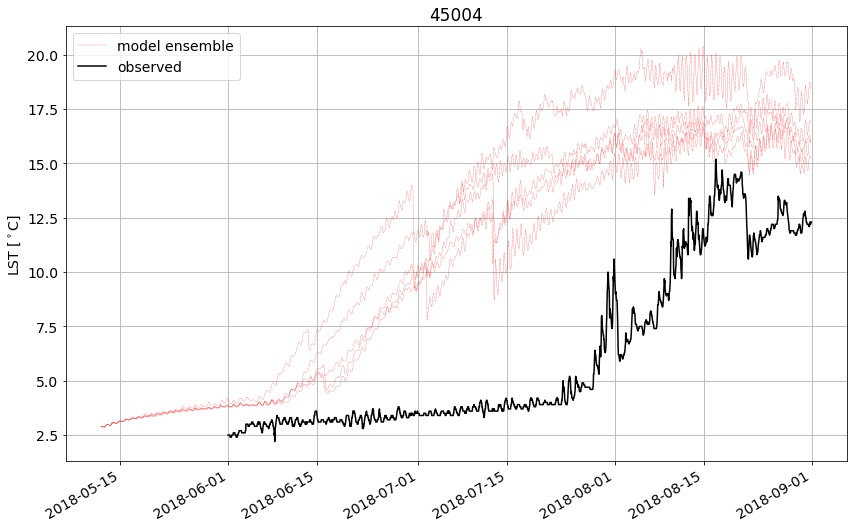

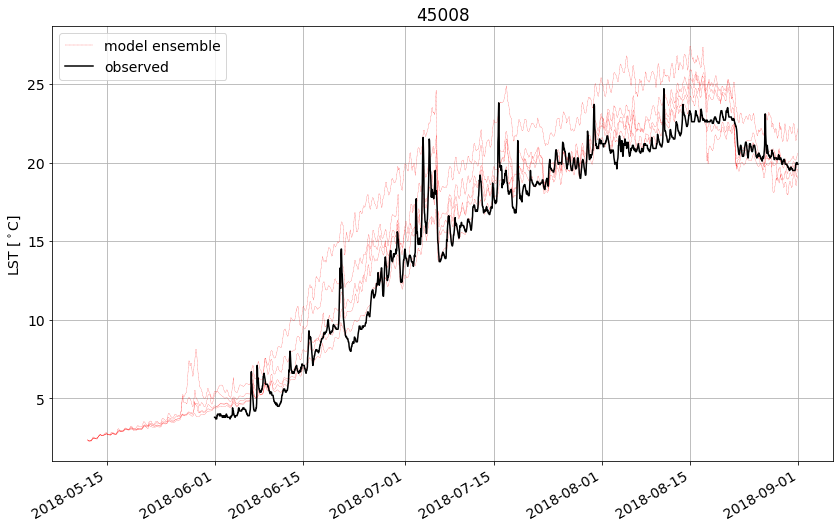

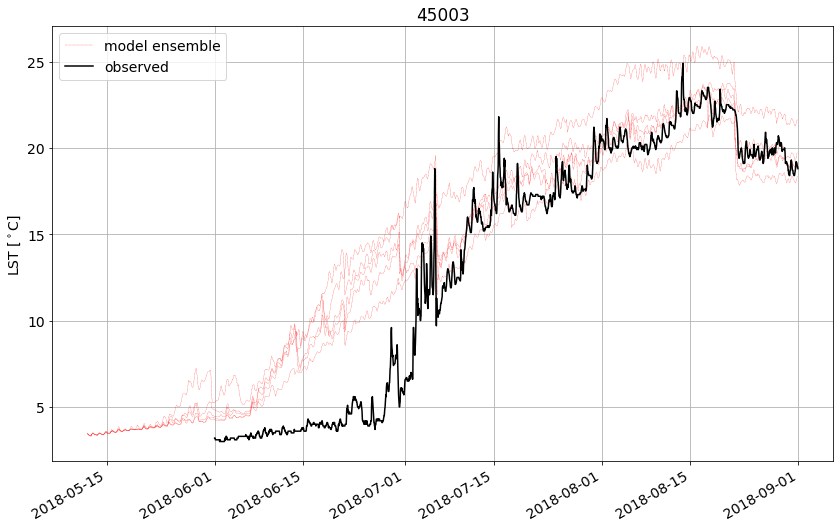

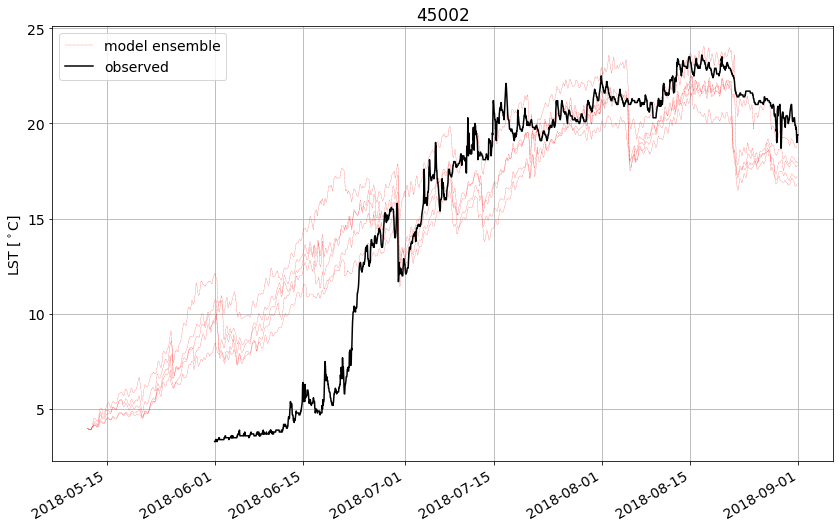

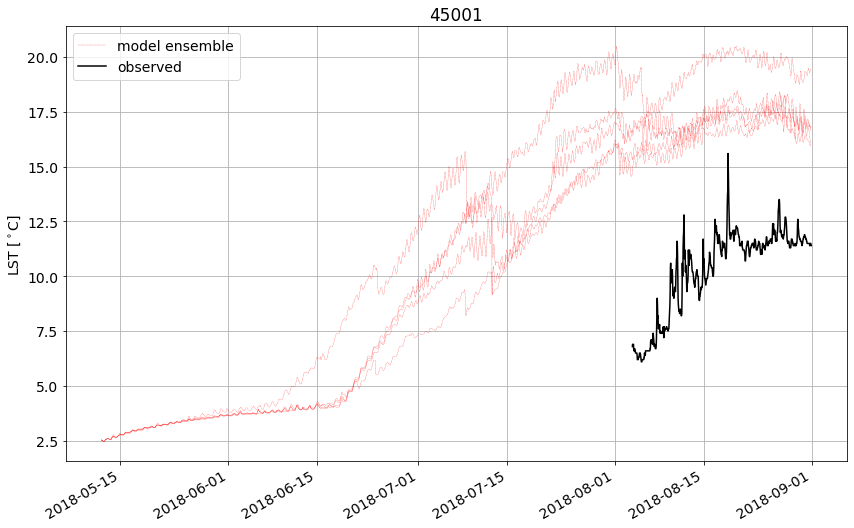

In [14]:
#LST
for bdx, bd in enumerate(buoy_data):
    fig = plt.figure(figsize=(14,8))

    # Download and add the states and coastlines
    buoy_name = buoy_names[bdx]
    
    # plot modeled time series
    for rdx, run in enumerate(wfv_runs['LST']):
        if rdx == 0:
            plt.plot(run[0],run[1][:,bdx],'r--',linewidth=0.25,label='model ensemble')
        else:
            plt.plot(run[0],run[1][:,bdx],'r--',linewidth=0.25)
        
    # plot observed time series
    plt.plot(bd['data']['time'],bd['data']['LST'],'k-',label='observed')

    plt.ylabel('LST [$^\circ$C]')
    plt.xticks(rotation=30, ha='right')
    plt.legend(loc='upper left')
    plt.title(buoy_name)
    plt.grid()
    plt.show()

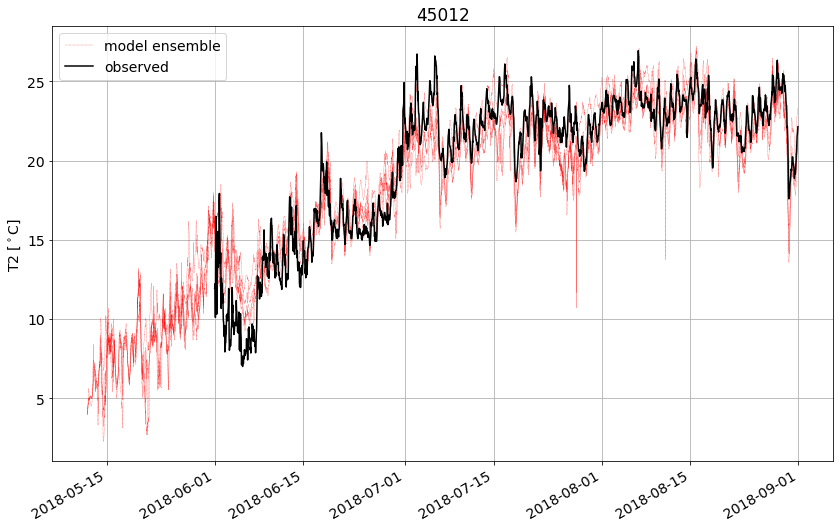

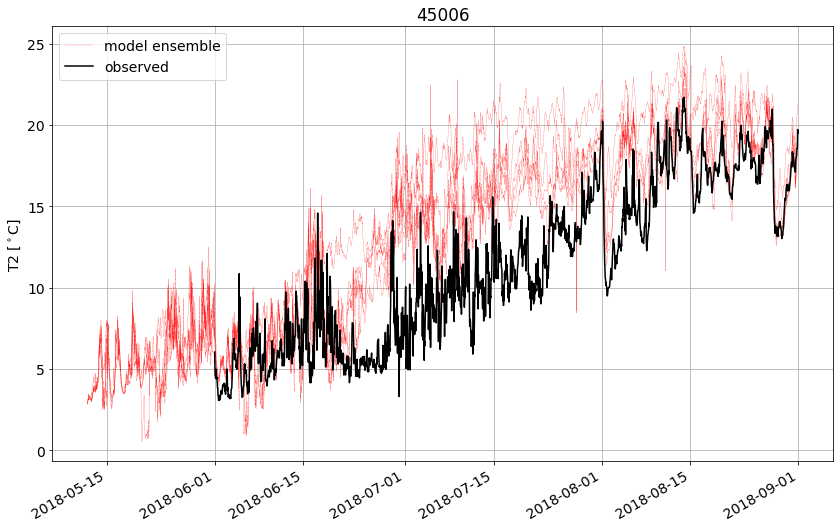

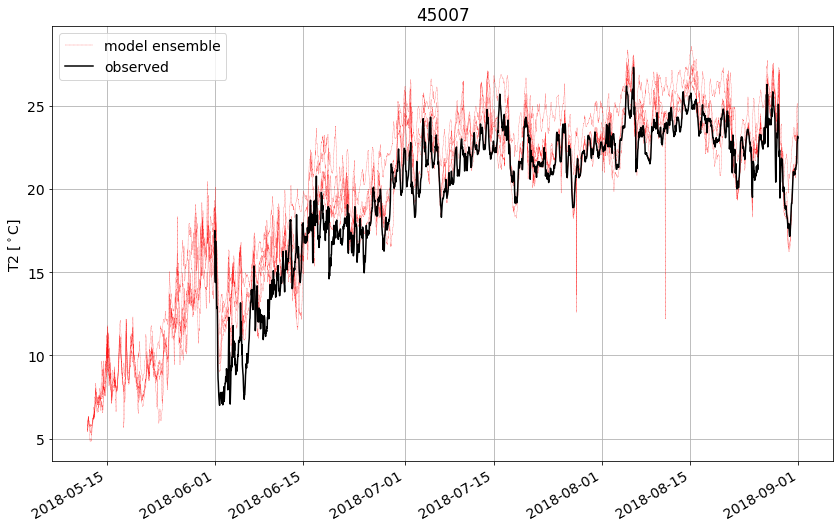

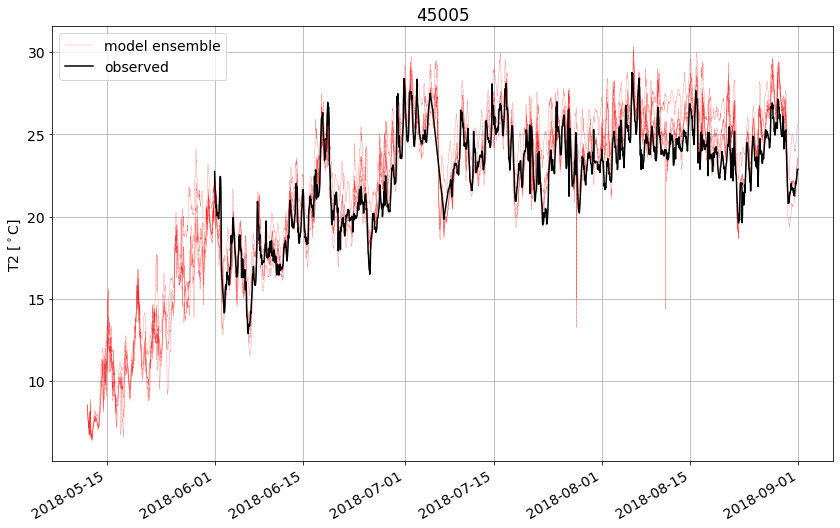

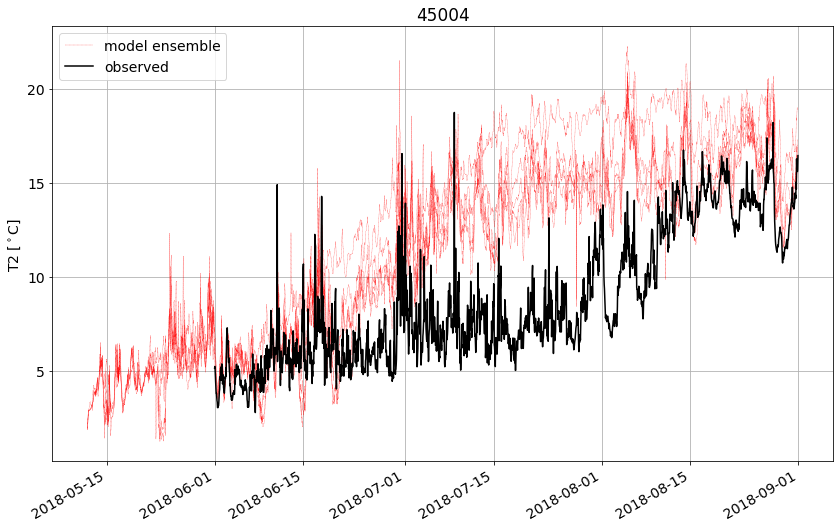

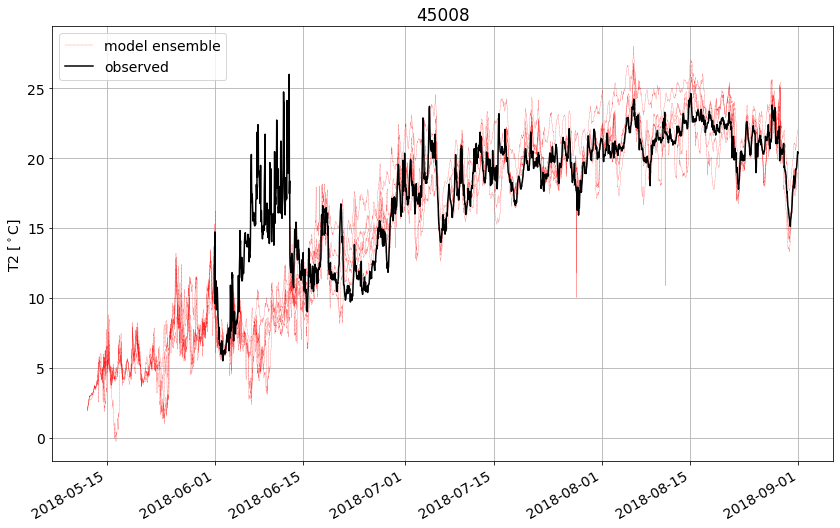

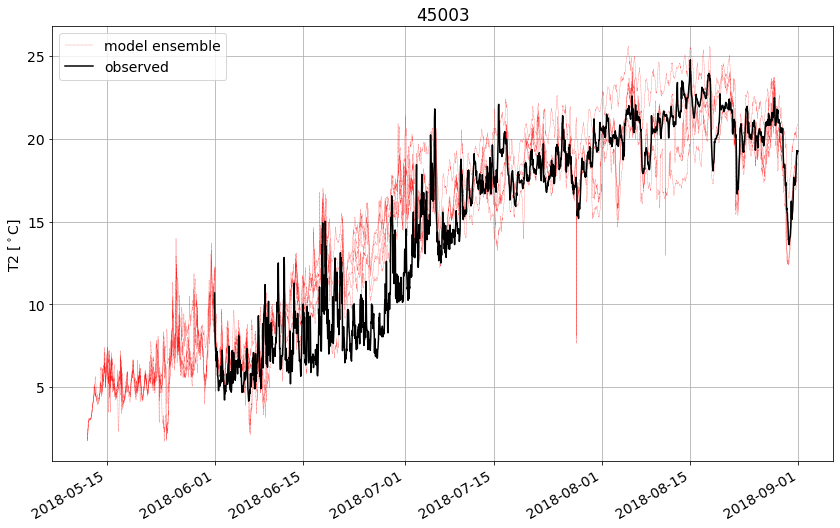

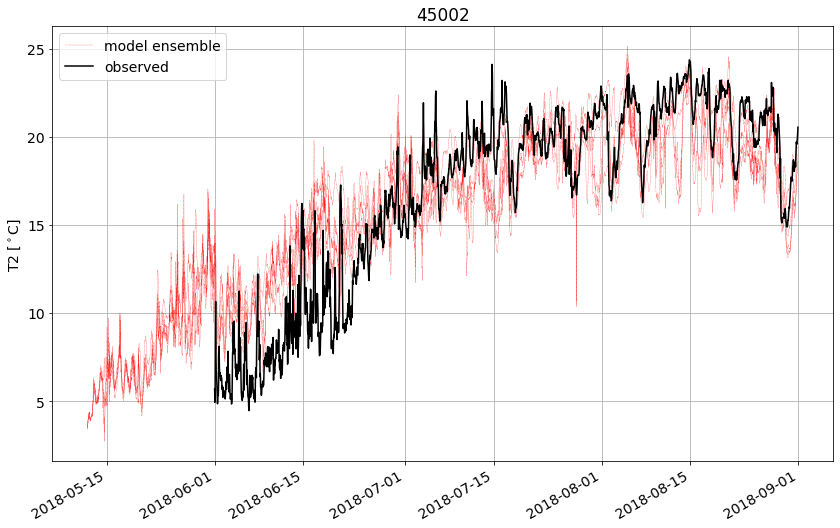

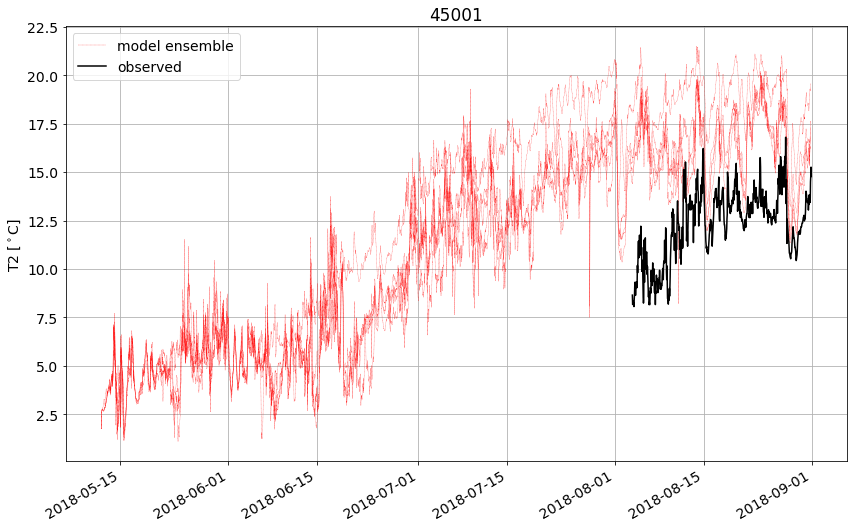

In [15]:
#T2
for bdx, bd in enumerate(buoy_data):
    fig = plt.figure(figsize=(14,8))

    # Download and add the states and coastlines
    buoy_name = buoy_names[bdx]
    
    # plot modeled time series
    for rdx, run in enumerate(wfv_runs['T2']):
        if rdx == 0:
            plt.plot(run[0],run[1][:,bdx],'r--',linewidth=0.25,label='model ensemble')
        else:
            plt.plot(run[0],run[1][:,bdx],'r--',linewidth=0.25)
        #if rdx < 19/2:
        #    plt.plot(run[0],run[1][:,bdx],'x--',linewidth=0.25,label=f'model ensemble {rdx+1}') 
        #else:
        #    plt.plot(run[0],run[1][:,bdx],'^--',linewidth=0.25,label=f'model ensemble {rdx+1}') 
        
    # plot observed time series
    plt.plot(bd['data']['time'],bd['data']['T2'],'k-',label='observed')

    plt.ylabel('T2 [$^\circ$C]')
    plt.xticks(rotation=30, ha='right')
    plt.legend(loc='upper left')
    plt.grid()
    plt.title(buoy_name)
    #plt.xlim([datetime(2018,8,1), datetime(2018,8,3)])
    plt.show()

## Processing all model sets with data 

In [39]:
# choose which set to do..
for this_dict in set_dict.values():
    # already exists..
    with open(this_dict['output_filename'], 'rb') as fp:
        wfv_runs = pickle.load(fp)
        
    print(f'processing timeseries in this file: {this_dict["output_filename"]}')
    this_dict['model_data_timeseries'] = align_model_with_observations(model=wfv_runs,data=buoy_data,
                                                                      remove)

processing timeseries in this file: ../output/wfv_buoy_temperature_training_set.pkl
earliest model end time: 2018-08-31T21:00:00
processing timeseries in this file: ../output/wfv_buoy_temperature_test_set.pkl
earliest model end time: 2018-08-31T21:00:00
processing timeseries in this file: ../output/wfv_buoy_temperature_BO1.pkl
earliest model end time: 2018-08-31T21:00:00


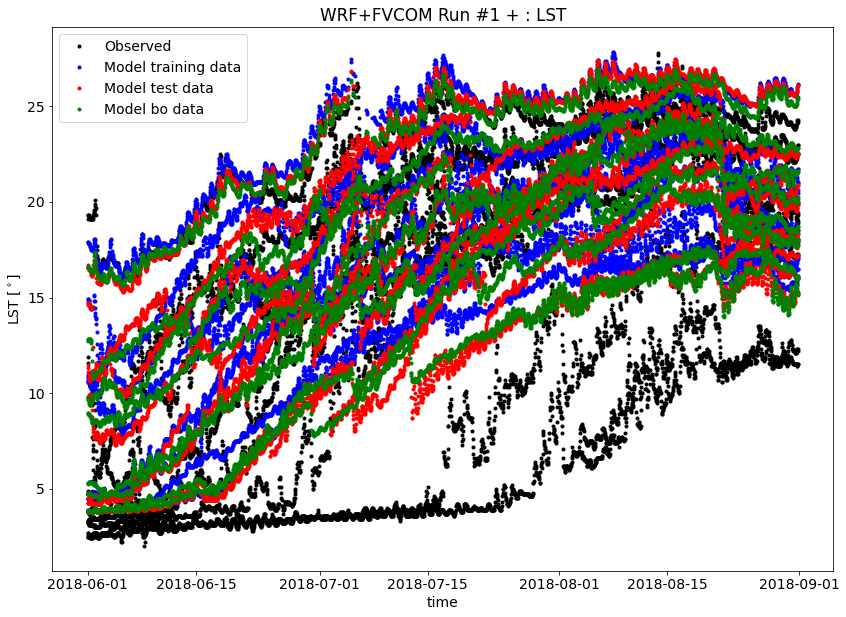

In [17]:
# Compare model data for LST
fig = plt.figure(figsize=(14,10))
this_data = set_dict['training_set']['model_data_timeseries']
plt.plot(this_data['time'],this_data['data']['LST'],'k.',label='Observed')
plt.plot(this_data['time'],this_data['model']['LST'][0,:],'b.', label='Model training data')
this_data = set_dict['test_set']['model_data_timeseries']
plt.plot(this_data['time'],this_data['model']['LST'][0,:],'r.', label='Model test data')
this_data = set_dict['bo_set']['model_data_timeseries']
plt.plot(this_data['time'],this_data['model']['LST'][0,:],'g.', label='Model bo data')
plt.xlabel('time')
plt.ylabel('LST [$^\circ$]')
plt.title("WRF+FVCOM Run #1 + : LST")
plt.legend()
plt.show()

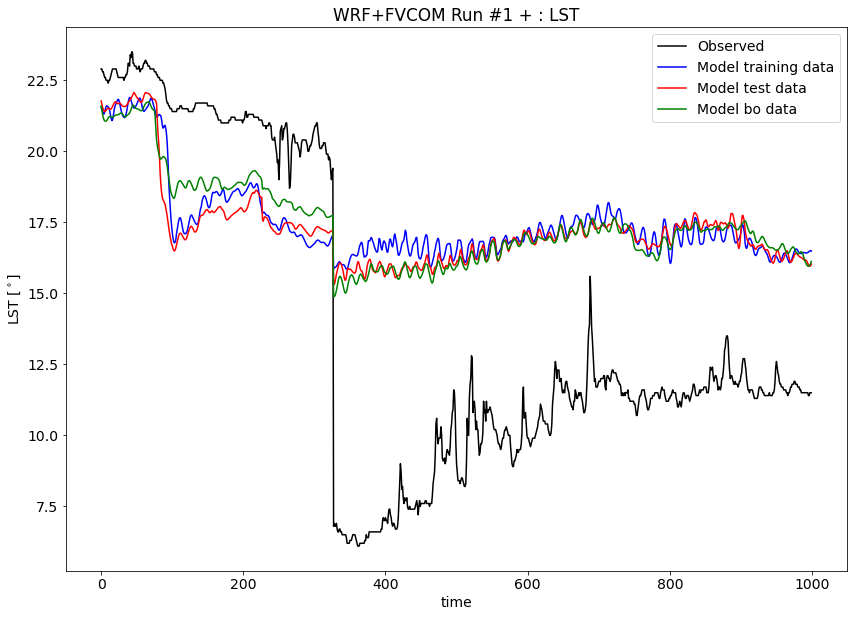

In [33]:
# Compare model data for LST
fig = plt.figure(figsize=(14,10))
this_data = set_dict['training_set']['model_data_timeseries']
plt.plot(this_data['data']['LST'][-1000::],'k-',label='Observed')
plt.plot(this_data['model']['LST'][0,-1000::],'b-', label='Model training data')
this_data = set_dict['test_set']['model_data_timeseries']
plt.plot(this_data['model']['LST'][0,-1000::],'r-', label='Model test data')
this_data = set_dict['bo_set']['model_data_timeseries']
plt.plot(this_data['model']['LST'][0,-1000::],'g-', label='Model bo data')
plt.xlabel('time')
plt.ylabel('LST [$^\circ$]')
plt.title("WRF+FVCOM Run #1 + : LST")
plt.legend()
plt.show()

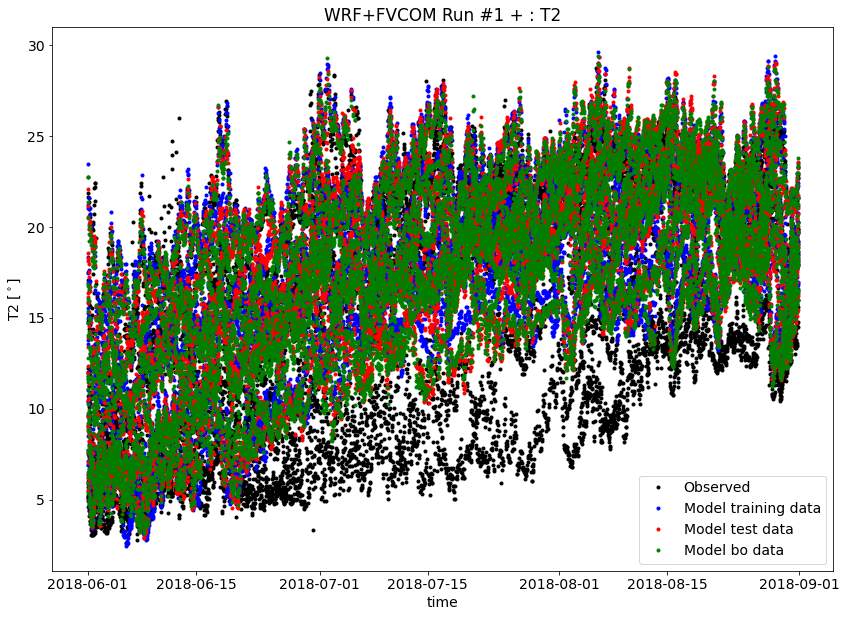

In [31]:
# Compare model data for T2
fig = plt.figure(figsize=(14,10))
this_data = set_dict['training_set']['model_data_timeseries']
plt.plot(this_data['time'],this_data['data']['T2'],'k.',label='Observed')
plt.plot(this_data['time'],this_data['model']['T2'][0,:],'b.', label='Model training data')
this_data = set_dict['test_set']['model_data_timeseries']
plt.plot(this_data['time'],this_data['model']['T2'][0,:],'r.', label='Model test data')
this_data = set_dict['bo_set']['model_data_timeseries']
plt.plot(this_data['time'],this_data['model']['T2'][0,:],'g.', label='Model bo data')
plt.xlabel('time')
plt.ylabel('T2 [$^\circ$]')
plt.title("WRF+FVCOM Run #1 + : T2")
plt.legend()
plt.show()

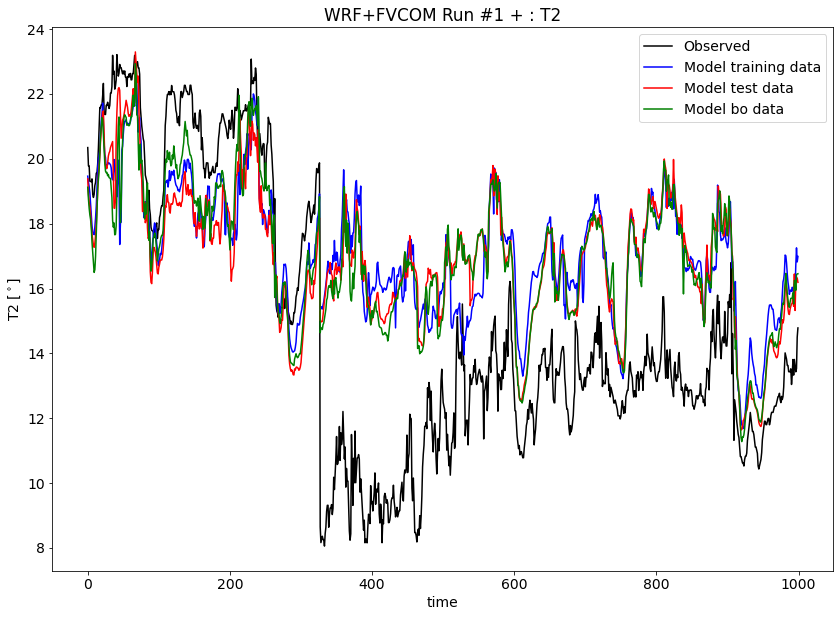

In [35]:
# Compare model data for T2
fig = plt.figure(figsize=(14,10))
this_data = set_dict['training_set']['model_data_timeseries']
plt.plot(this_data['data']['T2'][-1000::],'k-',label='Observed')
plt.plot(this_data['model']['T2'][0,-1000::],'b-', label='Model training data')
this_data = set_dict['test_set']['model_data_timeseries']
plt.plot(this_data['model']['T2'][0,-1000::],'r-', label='Model test data')
this_data = set_dict['bo_set']['model_data_timeseries']
plt.plot(this_data['model']['T2'][0,-1000::],'g-', label='Model bo data')
plt.xlabel('time')
plt.ylabel('T2 [$^\circ$]')
plt.title("WRF+FVCOM Run #1 + : T2")
plt.legend()
plt.show()

In [21]:
# save into pickle file
with open(all_output_filename, 'wb') as fp:
    pickle.dump(set_dict, fp)
    print('Written all processed data into the output binary file')

Written all processed data into the output binary file
